In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import sklearn as skl

In [68]:
df = pd.read_csv(r'D:\2024\Kaggle\playground-series-s5e5\train.csv').drop(columns=['id'])
extra_df = pd.read_csv(r'D:\2024\Kaggle\playground-series-s5e5\extra_data.csv').drop(columns=['User_ID'])
df_test = pd.read_csv(r'D:\2024\Kaggle\playground-series-s5e5\test.csv').drop(columns=['id'])
extra_df.columns = df.columns
df = pd.concat([df,extra_df], ignore_index=True)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765000 entries, 0 to 764999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         765000 non-null  object 
 1   Age         765000 non-null  int64  
 2   Height      765000 non-null  float64
 3   Weight      765000 non-null  float64
 4   Duration    765000 non-null  float64
 5   Heart_Rate  765000 non-null  float64
 6   Body_Temp   765000 non-null  float64
 7   Calories    765000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 46.7+ MB


In [46]:
df.describe()

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,765000.000000,765000.000000,765000.000000,765000.000000,765000.000000,765000.000000,765000.000000
mean,41.447255,174.693126,75.142162,15.423163,95.484672,40.036041,88.307424
std,15.213677,12.854173,14.004122,8.353421,9.452476,0.779863,62.396760
min,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [69]:
df.columns

Index(['Sex', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Calories'],
      dtype='object')

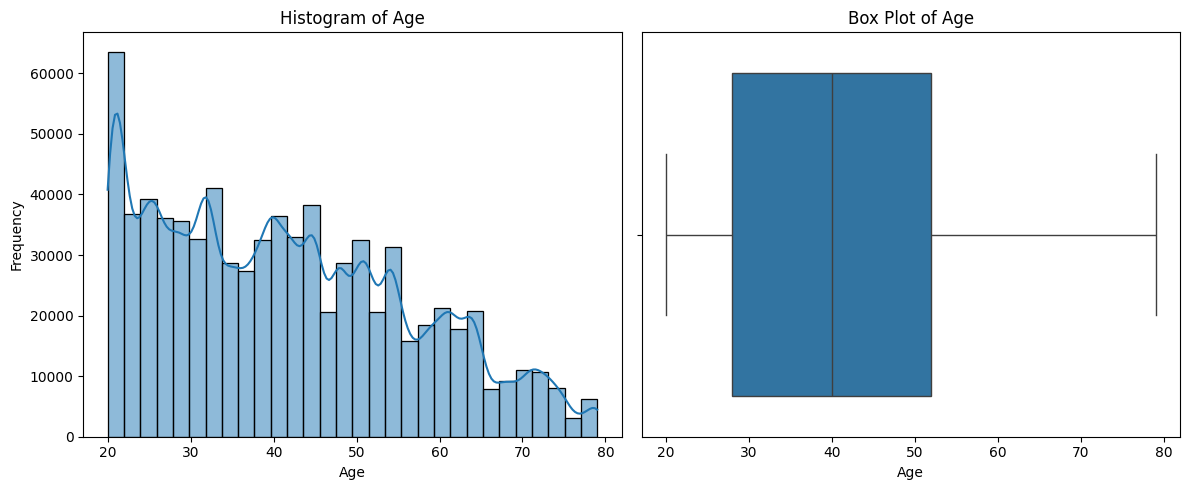


Statistics for Age:
Skewness: 0.44
Number of Missing Values: 0


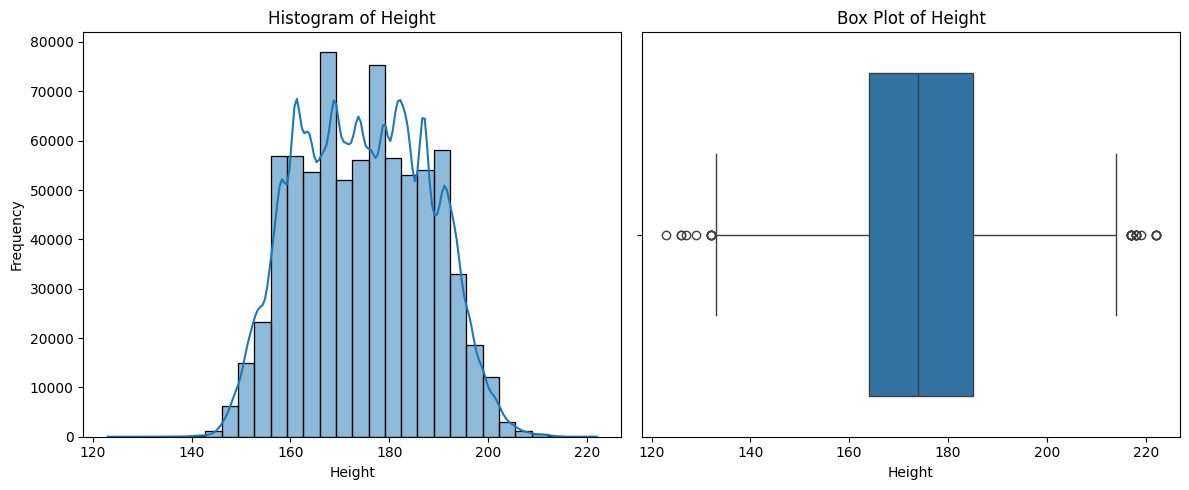


Statistics for Height:
Skewness: 0.05
Number of Missing Values: 0


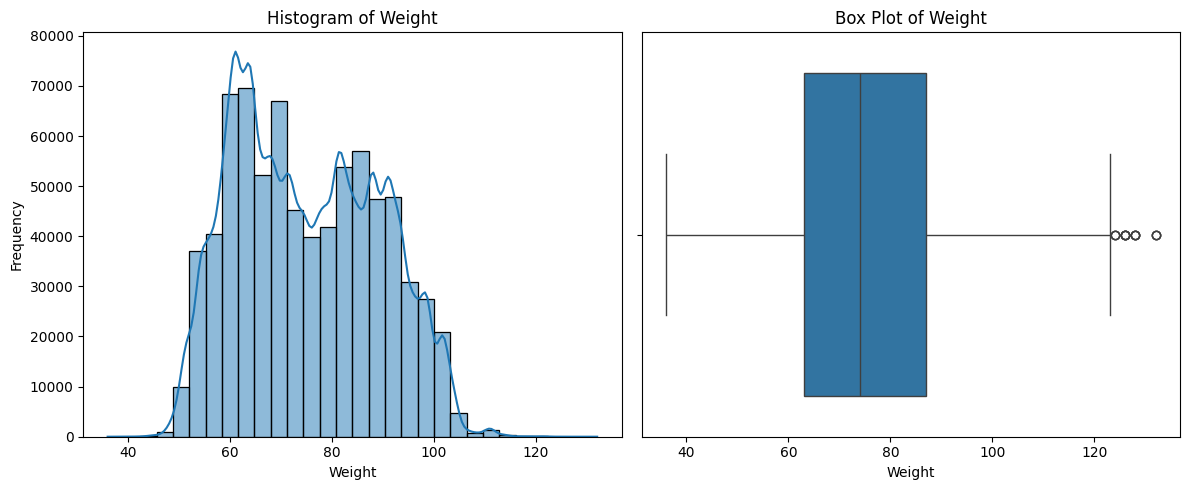


Statistics for Weight:
Skewness: 0.21
Number of Missing Values: 0


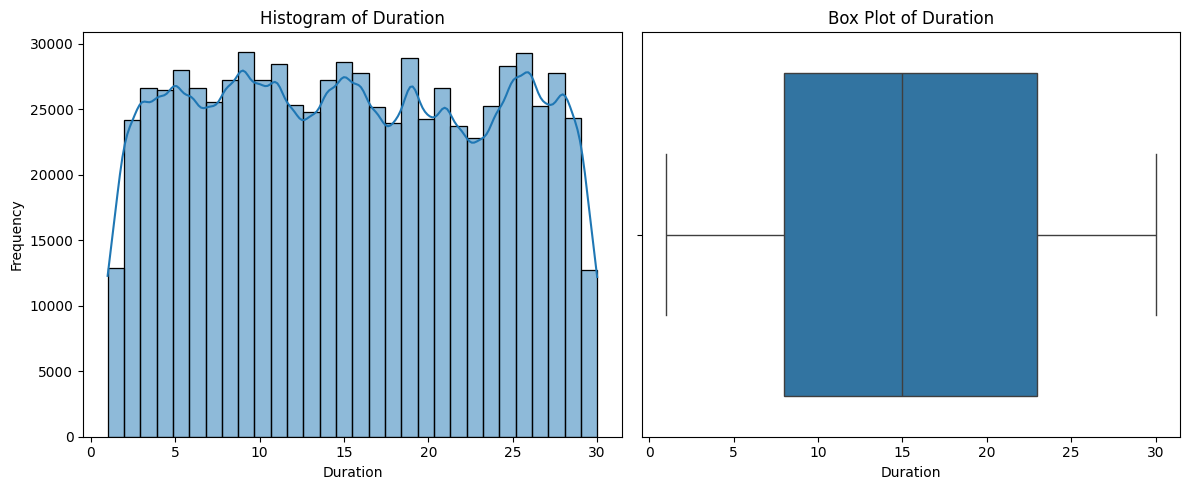


Statistics for Duration:
Skewness: 0.03
Number of Missing Values: 0


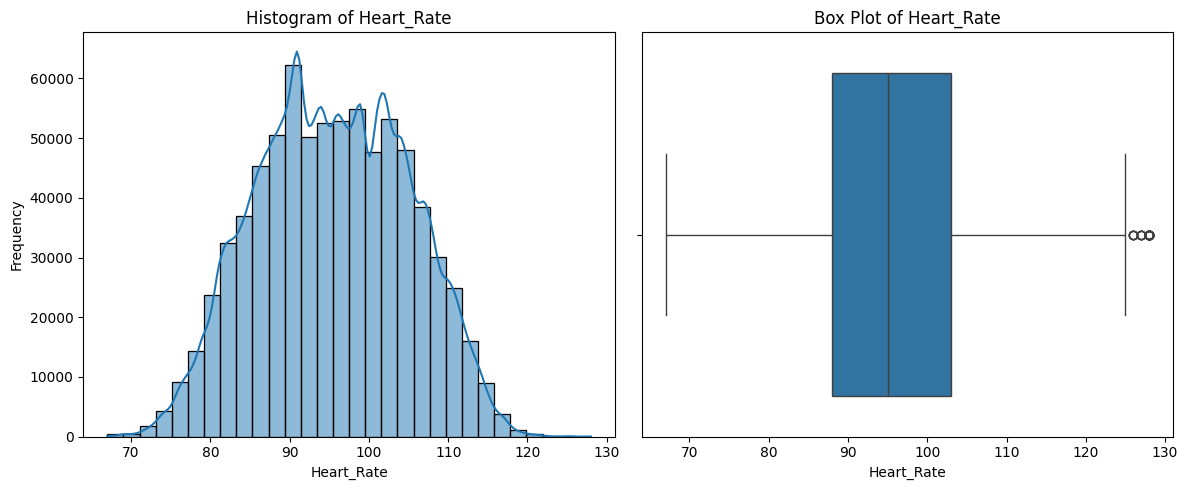


Statistics for Heart_Rate:
Skewness: -0.01
Number of Missing Values: 0


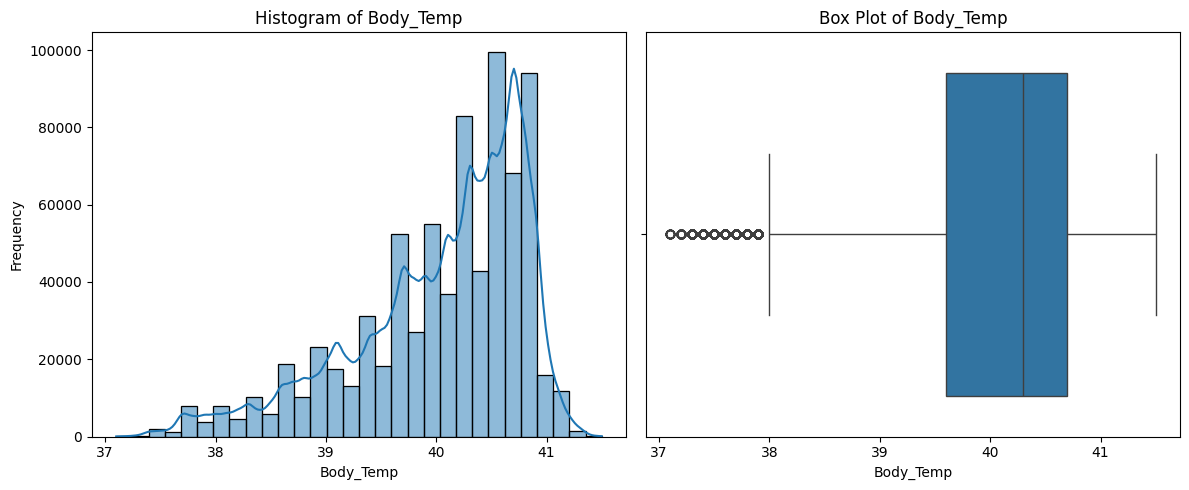


Statistics for Body_Temp:
Skewness: -1.02
Number of Missing Values: 0


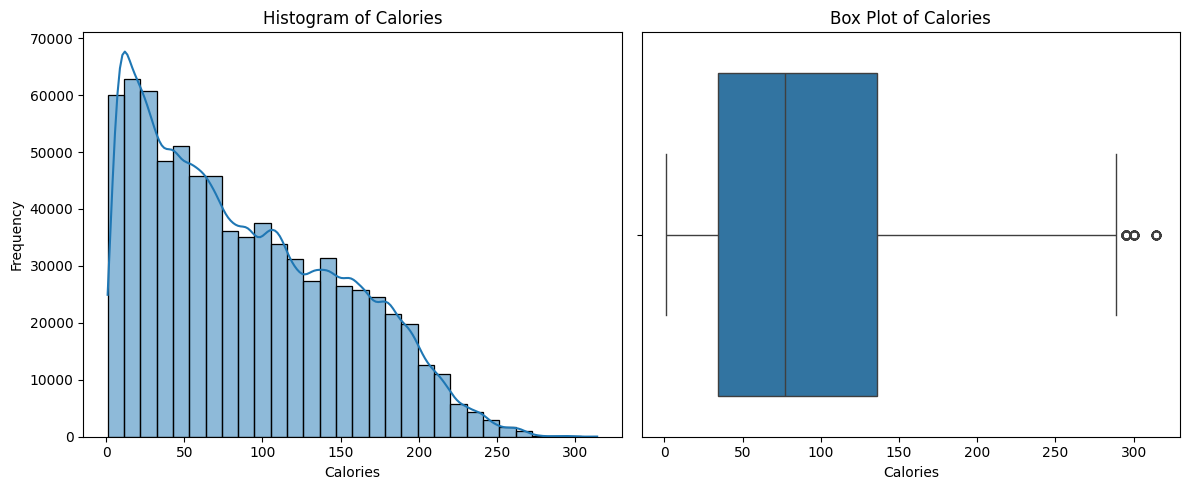


Statistics for Calories:
Skewness: 0.54
Number of Missing Values: 0


In [48]:
numerical_features = [
    "Age",
    "Height",
    "Weight",
    "Duration",
    "Heart_Rate",
    "Body_Temp",
    "Calories"
    
]

for feature in numerical_features:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature])
    plt.title(f"Box Plot of {feature}")

    plt.tight_layout()
    plt.show()

    print(f"\nStatistics for {feature}:")
    print(f"Skewness: {df[feature].skew():.2f}")
    print(f"Number of Missing Values: {df[feature].isnull().sum()}")

In [66]:
numerical_columns = df.drop(columns=['Calories','Sex']).columns.to_list()

for col in numerical_columns:
    Q1 = df.loc[:, col].quantile(0.25)
    Q3 = df.loc[:, col].quantile(0.75)
    IQR = Q3 - Q1
    upperBoundary = df.loc[:, col].median() + 1.5 * IQR
    lowerBoundary = df.loc[:, col].median() - 1.5 * IQR
    df = df.loc[(df.loc[:, col] <= upperBoundary) & (df.loc[:, col] >= lowerBoundary)]

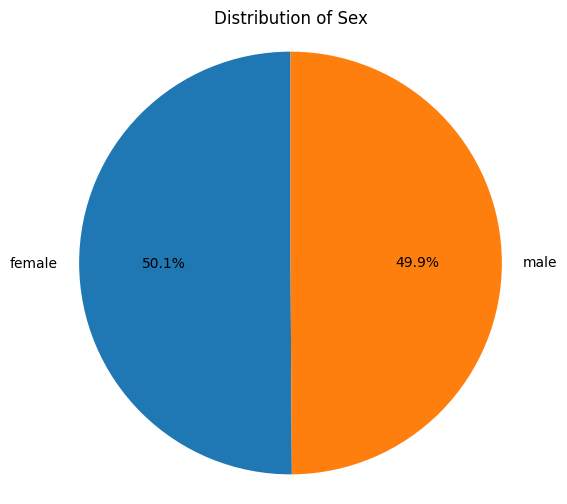

In [70]:
sex_counts = df["Sex"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Distribution of Sex")
plt.axis("equal")
plt.show()

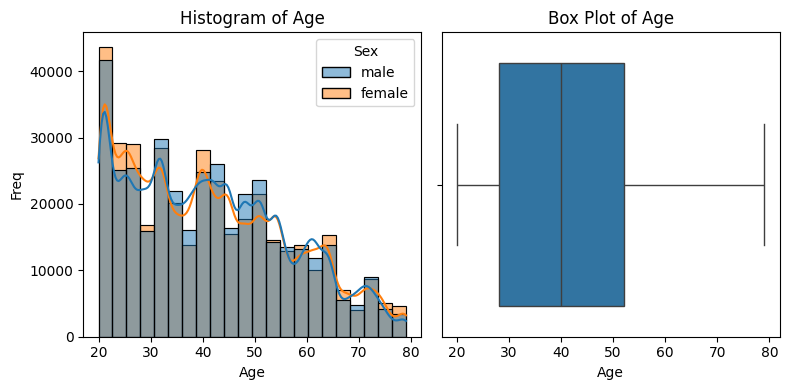

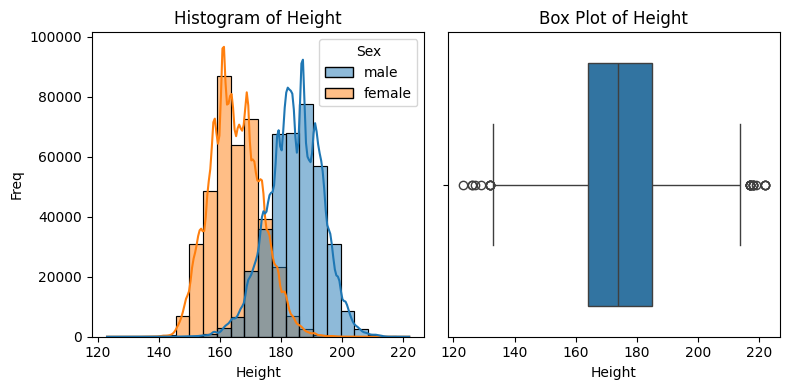

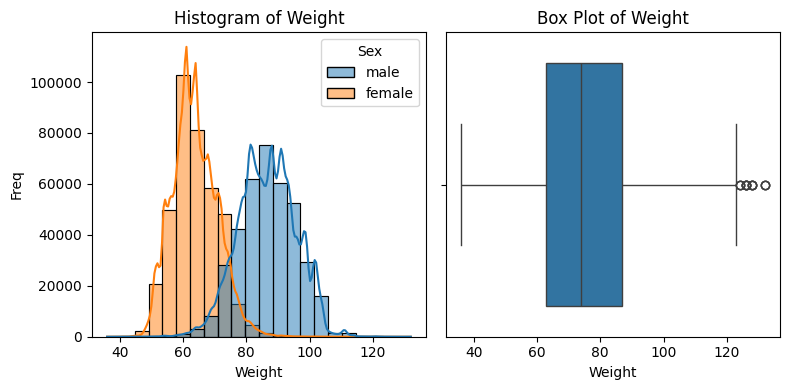

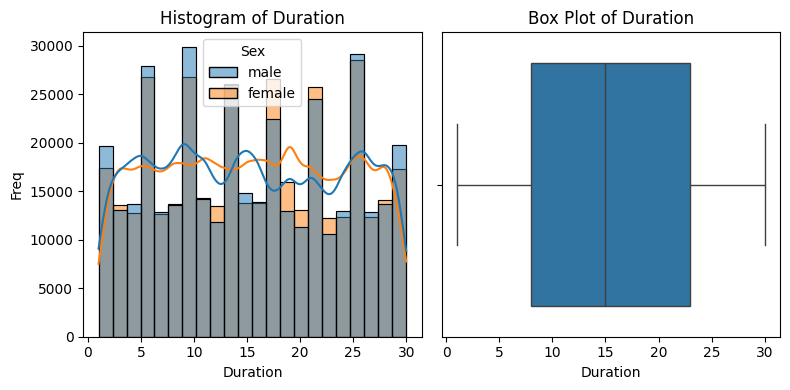

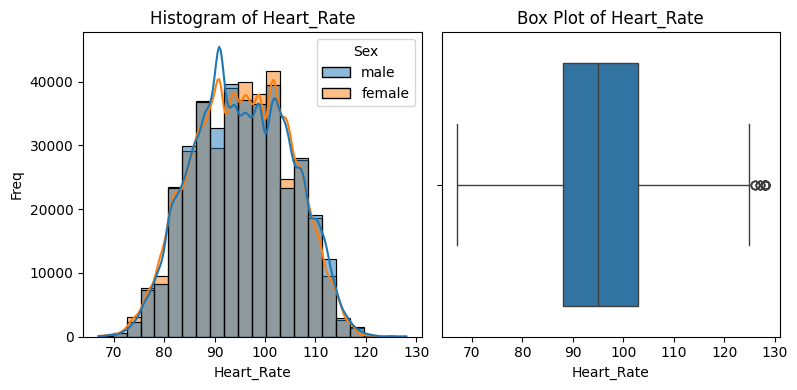

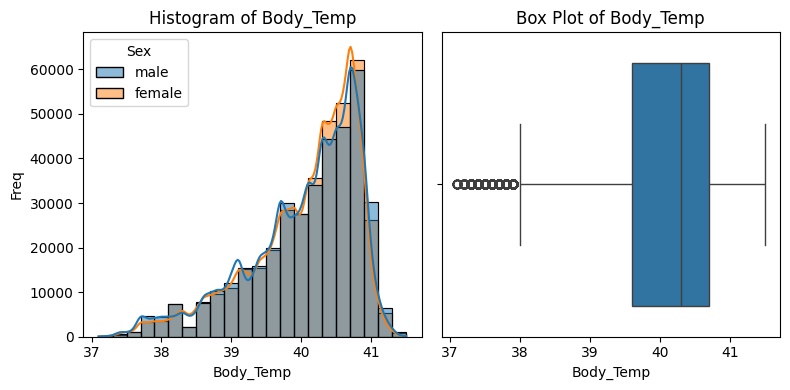

In [71]:
for cat in numerical_columns:
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    sns.histplot(data=df, x=df[cat], kde=True, hue='Sex', bins=22)
    plt.title(f'Histogram of {cat}')
    plt.xlabel(cat)
    plt.ylabel('Freq')

    plt.subplot(1,2,2)
    sns.boxplot(x=df[cat])
    plt.title(f'Box Plot of {cat}')

    plt.tight_layout()
    plt.show()

In [72]:
df['BMI'] = df['Weight'] / ((df['Height']/100)**2)
# df['HeartRate_per_min'] = df['Heart_Rate'] / df['Duration']
# df['Weight_per_min'] = df['Weight'] / df['Duration']
df['Sex'] = df['Sex'].map({'male':1,'female':0})
df['BMR']=0
df.loc[df.Sex==0,'BMR'] = df['Weight'] * 9.65 + (df['Height'] / 100) * 573 - df['Age'] * 5.08 + 260
df.loc[df.Sex==1,'BMR'] = df['Weight'] * 7.38 + (df['Height'] / 100) * 607 - df['Age'] * 2.31 + 43

df_test['BMI'] = df_test['Weight'] / ((df_test['Height']/100)**2)
# df_test['HeartRate_per_min'] = df_test['Heart_Rate'] / df_test['Duration']
# df_test['Weight_per_min'] = df_test['Weight'] / df_test['Duration']
df_test['Sex'] = df_test['Sex'].map({'male':1,'female':0})
df_test['BMR']=0
df_test.loc[df_test.Sex==0,'BMR'] = df_test['Weight'] * 9.65 + (df_test['Height'] / 100) * 573 - df_test['Age'] * 5.08 + 260
df_test.loc[df_test.Sex==1,'BMR'] = df_test['Weight'] * 7.38 + (df_test['Height'] / 100) * 607 - df_test['Age'] * 2.31 + 43

# 訓練XGBoost
---

In [62]:
df.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,BMI,HeartRate_per_min,Weight_per_min,BMR
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,22.955684,3.884615,3.153846,1712.23
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,22.582709,10.625000,7.500000,1447.87
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,24.690405,12.000000,9.142857,1541.05
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,24.414062,4.200000,3.600000,1826.44
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,22.136740,4.080000,2.440000,1606.79


c:\Users\groundwater\anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:158: UserWarning: [18:07:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Fold 1 RMSLE_train: 0.0181 RMSLE_val: 0.0192
Fold 2 RMSLE_train: 0.0181 RMSLE_val: 0.0175
Fold 3 RMSLE_train: 0.0181 RMSLE_val: 0.0183
Fold 4 RMSLE_train: 0.0181 RMSLE_val: 0.0179
Fold 5 RMSLE_train: 0.0181 RMSLE_val: 0.0177
Fold 6 RMSLE_train: 0.0181 RMSLE_val: 0.0173
Fold 7 RMSLE_train: 0.0181 RMSLE_val: 0.0186
Fold 8 RMSLE_train: 0.0181 RMSLE_val: 0.0179
Fold 9 RMSLE_train: 0.0181 RMSLE_val: 0.0189
Fold 10 RMSLE_train: 0.0181 RMSLE_val: 0.0188
Fold 11 RMSLE_train: 0.0181 RMSLE_val: 0.0180
Fold 12 RMSLE_train: 0.0181 RMSLE_val: 0.0185
Fold 13 RMSLE_train: 0.0181 RMSLE_val: 0.0180
Fold 14 RMSLE_train: 0.0181 RMSLE_val: 0.0183
Fold 15 RMSLE_train: 0.0181 RMSLE_val: 0.0182
Fold 16 RMSLE_train: 0.0181 RMSLE_val: 0.0185
Fold 17 RMSLE_train: 0.0181 RMSLE_val: 0.0195
Fold 18 RMSLE_train: 0.0181 RMSLE_val: 0.0180
Fold 19 RMSLE_train: 0.0181 RMSLE_val: 0.0179
Fold 20 RMSLE_train: 0.0181 RMSLE_val: 0.0186
Fold 21 RMSLE_train: 0.0181 RMSLE_val: 0.0184
Fold 22 RMSLE_train: 0.0181 RMSLE_val: 0.01

<Figure size 1000x600 with 0 Axes>

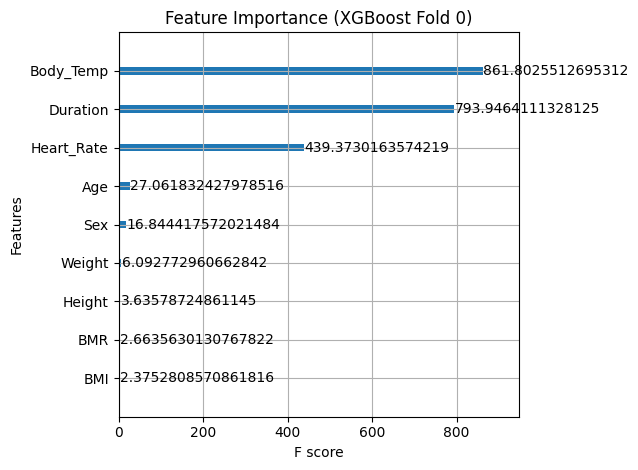

In [75]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor, plot_importance

X = df.drop(columns=['Calories'])
y = np.log1p(df['Calories'])

# KFold 設定
kf = KFold(n_splits=50, shuffle=True, random_state=42)
rmsle_scores = []
models = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = XGBRegressor(
        objective='reg:squarederror',  # Regression task
        colsample_bytree=0.3,          # Subsample ratio of columns
        learning_rate=0.1,             # Step size at each iteration
        max_depth=4,                   # Maximum depth of a tree
        alpha=10,                      # L2 regularization term
        n_estimators=1000,             # Number of trees
        random_state=42,
        tree_method="hist",
        device="cuda"
    )


    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
    rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_pred_val))
    rmsle_scores.append(rmsle_val)
    models.append(model)

    print(f"Fold {fold + 1} RMSLE_train: {rmsle_train:.4f} RMSLE_val: {rmsle_val:.4f}")

print(f"\nAverage RMSLE: {np.mean(rmsle_scores):.4f}")

# 繪製特徵重要性（第一折）
plt.figure(figsize=(10, 6))
plot_importance(models[1], max_num_features=15, importance_type='gain')
plt.title("Feature Importance (XGBoost Fold 0)")
plt.tight_layout()
plt.show()

In [76]:
df_test.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,BMI,BMR
0,1,45,177.0,81.0,7.0,87.0,39.8,25.854639,1611.22
1,1,26,200.0,97.0,20.0,101.0,40.5,24.250000,1912.80
2,0,29,188.0,85.0,16.0,102.0,40.4,24.049344,2010.17
3,0,39,172.0,73.0,20.0,107.0,40.6,24.675500,1751.89
4,0,30,173.0,67.0,16.0,94.0,40.5,22.386314,1745.44


In [77]:
X_test = df_test
y_test = model.predict(X_test)
y_test = np.expm1(y_test)

sub = pd.read_csv(r'D:\2024\Kaggle\playground-series-s5e5\sample_submission.csv',index_col='id')

In [80]:
sub['Calories'] = y_test
sub

,Calories
id,
750000,27.464727
750001,107.181641
750002,87.637184
750003,127.290985
750004,76.244873
...,...
999995,26.923662
999996,9.251095
999997,73.333046


In [79]:
sub.to_csv(r'D:\2024\Kaggle\playground-series-s5e5\sub.csv')

訓練 ANN
---

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
from tensorflow.keras import layers, models, callbacks

# 分離特徵與目標
X = df.drop(columns=['Calories'])
y = np.log1p(df['Calories'])

# 特徵標準化（對 ANN 很重要）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 切分訓練/驗證集
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# === 建立 ANN 模型 ===
input_dim = X_train.shape[1]
inputs = layers.Input(shape=(input_dim,), name='input')

x = layers.BatchNormalization(epsilon=1.001e-5, name='bn_0')(inputs)
x = layers.ReLU(name='relu_0')(x)
x = layers.Dense(128, use_bias=False, name='dense_1')(x)

x = layers.BatchNormalization(epsilon=1.001e-5, name='bn_1')(x)
x = layers.ReLU(name='relu_1')(x)
x = layers.Dense(64, use_bias=False, name='dense_2')(x)

x = layers.BatchNormalization(epsilon=1.001e-5, name='bn_2')(x)
x = layers.ReLU(name='relu_2')(x)

outputs = layers.Dense(1, name='output')(x)

model = models.Model(inputs, outputs, name='tabular_ann')
model.compile(optimizer='adam', loss='mse')
model.summary()

# === 訓練模型 ===
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=256,
    callbacks=[es],
    verbose=1
)

y_pred = model.predict(X_val).flatten()
y_pred = np.expm1(y_pred)  # 還原 log1p 的結果
rmsle = np.sqrt(mean_squared_log_error(np.expm1(y_val), y_pred))

Model: "tabular_ann"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 11)]              0         
_________________________________________________________________
bn_0 (BatchNormalization)    (None, 11)                44        
_________________________________________________________________
relu_0 (ReLU)                (None, 11)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1408      
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 128)               512       
_________________________________________________________________
relu_1 (ReLU)                (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                

In [60]:
X = df_test
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X)
y_test = model.predict(X_test_scaled)
y_test = np.expm1(y_test)

sub = pd.read_csv(r'D:\2024\Kaggle\playground-series-s5e5\sample_submission.csv',index_col='id')
sub['Calories'] = y_test
sub

,Calories
id,
750000,46.672394
750001,115.080223
750002,94.494545
750003,138.281647
750004,86.504372
...,...
999995,41.600464
999996,21.175552
999997,79.514999


In [61]:
sub.to_csv(r'D:\2024\Kaggle\playground-series-s5e5\sub_ANN.csv')